In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

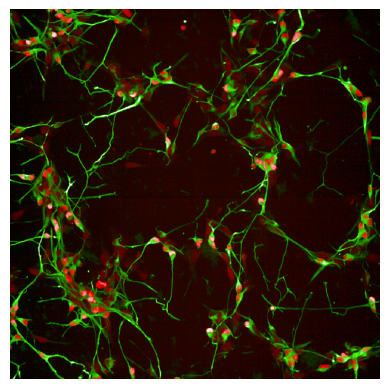

In [5]:
#neurite_image=cv2.imread('d:\\downloads\\temp\\neurite\\segmentation_image_fiji\\weka_13.tif',-1) # -1 represent to keep the raw type of the image
neurite_image=cv2.imread('d:\\downloads\\temp\\neurite\\ALS_Stress\\ALS_iMN_Isogenics\\HOM14_CTRL_Day28_20x (5).dib',-1)
# To check whether the image can be read successfully
if neurite_image is None:
    print("Can not load the image, please check whether the image's path and format is correct")
else:
    # Check whether the image is single channel or double channel
    if len(neurite_image.shape) == 2:  # Single Channel grayscale image
        plt.imshow(neurite_image, cmap='gray')
    else:  # Color image
        neurite_image_rgb = cv2.cvtColor(neurite_image, cv2.COLOR_BGR2RGB)
        plt.imshow(neurite_image_rgb)

    # Show image
    plt.axis('off')  # Hide axis
    plt.show()

The things related to image loading, including grayscale image 

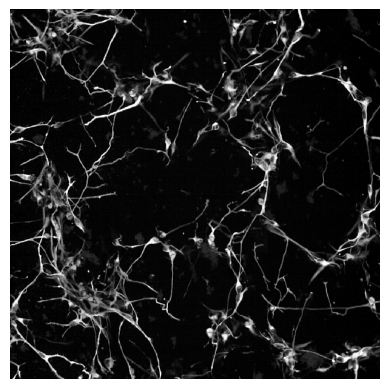

In [8]:
# Can deal with the bitmap format image, this is the format without semantic segmentation
neurite_image=cv2.imread('d:\\downloads\\temp\\neurite\ALS_Stress\\iMN_green\\HOM14_Rot_Day28_20x (5).bmp',-1)
#neurite_image=cv2.medianBlur(neurite_image, 3)
#neurite_image = cv2.fastNlMeansDenoising(neurite_image, None, 10, 7, 21)
plt.imshow(neurite_image, cmap='gray') # If we want to show the image, we have to add "cmap='gray'"，otherwise the Matplotlib can not show the image
plt.axis('off')  # Hide axis
plt.show()

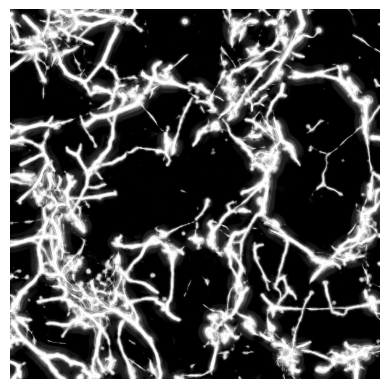

In [10]:
# Can deal with the tif format images, this is the format after semantic segmentation
binary_neurite_image=cv2.imread('d:\\downloads\\temp\\neurite\\ALS_Stress\\seg_imn_pic\\HOM14_CTRL_Day28_20x (5).tif',-1)
#neurite_image=cv2.medianBlur(neurite_image, 3)
#neurite_image = cv2.fastNlMeansDenoising(neurite_image, None, 10, 7, 21)
plt.imshow(binary_neurite_image, cmap='gray') 
plt.axis('off')  # Hide axis
plt.show()

Transform the image into grayscale image

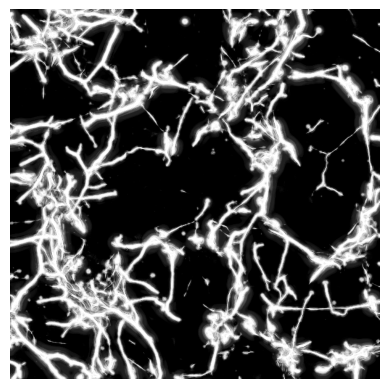

In [11]:
if binary_neurite_image.dtype == np.uint16:
    # transform to uint8 type
    binary_neurite_image = cv2.normalize(binary_neurite_image, None, 0, 255, cv2.NORM_MINMAX)
    binary_neurite_image = binary_neurite_image.astype(np.uint8)
elif binary_neurite_image.dtype == np.float32 or binary_neurite_image.dtype == np.float64:
    # If it is float format, also needs to transform into uint8 format
    binary_neurite_image = cv2.normalize(binary_neurite_image, None, 0, 255, cv2.NORM_MINMAX)
    binary_neurite_image = binary_neurite_image.astype(np.uint8)

plt.imshow(binary_neurite_image, cmap='gray')  
plt.axis('off')
plt.show()

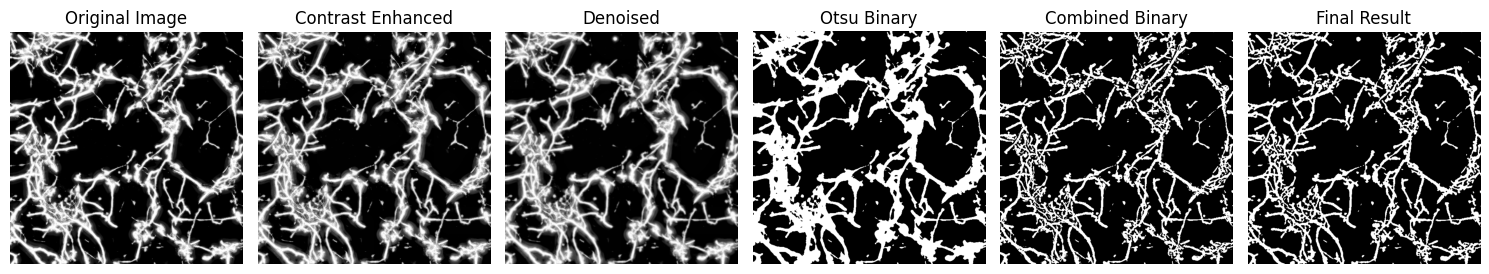

In [12]:
# Step 1: Increae contrast level（CLAHE）
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Decrease the tileGridSize to better handle localized areas
contrast_enhanced = clahe.apply(binary_neurite_image)

# Step 2: Denoising (using Gaussian filtering instead of median filtering to better preserve edges)
denoised_image = cv2.GaussianBlur(contrast_enhanced, (3, 3), 0)

# Step 3: Combination of Otsu thresholding method and adaptive thresholding
# First use Otsu's method to get the global thresholds
_, otsu_binary = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Then use adptative threshold
adaptive_binary = cv2.adaptiveThreshold(
    denoised_image, 
    255,                               # image size
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    11,  # The smaller neighborhood size. the more detail to retain 
    2    # Positive to maintain proper contrast
)

# Combine two binary process
combined_binary = cv2.bitwise_and(otsu_binary, adaptive_binary)

# Step 4: morphological operation
kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Start with a slight open operation to remove the noise
opened = cv2.morphologyEx(combined_binary, cv2.MORPH_OPEN, kernel_small)

# Then a closed operation is performed to connect the disconnected parts
morphed_image = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_medium)

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 6, 1)
plt.title("Original Image")
plt.imshow(binary_neurite_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 6, 2)
plt.title("Contrast Enhanced")
plt.imshow(contrast_enhanced, cmap='gray')
plt.axis('off')

plt.subplot(1, 6, 3)
plt.title("Denoised")
plt.imshow(denoised_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 6, 4)
plt.title("Otsu Binary")
plt.imshow(otsu_binary, cmap='gray')
plt.axis('off')

plt.subplot(1, 6, 5)
plt.title("Combined Binary")
plt.imshow(combined_binary, cmap='gray')
plt.axis('off')

plt.subplot(1, 6, 6)
plt.title("Final Result")
plt.imshow(morphed_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Compute neurite area
original_white_pixels = np.sum(morphed_image== 255)
total_pixels = binary_neurite_image.size
area_ratio = (original_white_pixels / total_pixels) * 100
print(f"The percentage of the neurite in the whole image is：{area_ratio:.2f}%")

The percentage of the neurite in the whole image is：23.14%


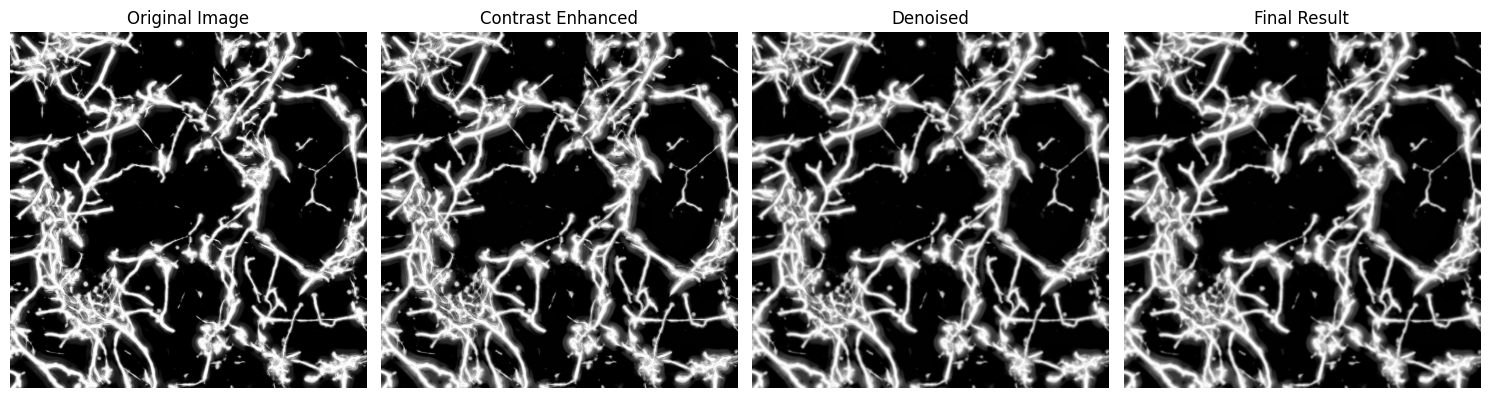

The average Neurite intensity is: 30.23%


In [14]:
# Compute neurite intensity of the image
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
contrast_enhanced = clahe.apply(binary_neurite_image) 

denoised_image = cv2.GaussianBlur(contrast_enhanced, (3, 3), 0)

kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

opened = cv2.morphologyEx(denoised_image, cv2.MORPH_OPEN, kernel_small)

processed_image = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_medium)

plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(binary_neurite_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Contrast Enhanced")
plt.imshow(contrast_enhanced, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Denoised")
plt.imshow(denoised_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Final Result")
plt.imshow(processed_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

mean_intensity = np.mean(processed_image)/255.0*100
print(f"The average Neurite intensity is: {mean_intensity:.2f}%")

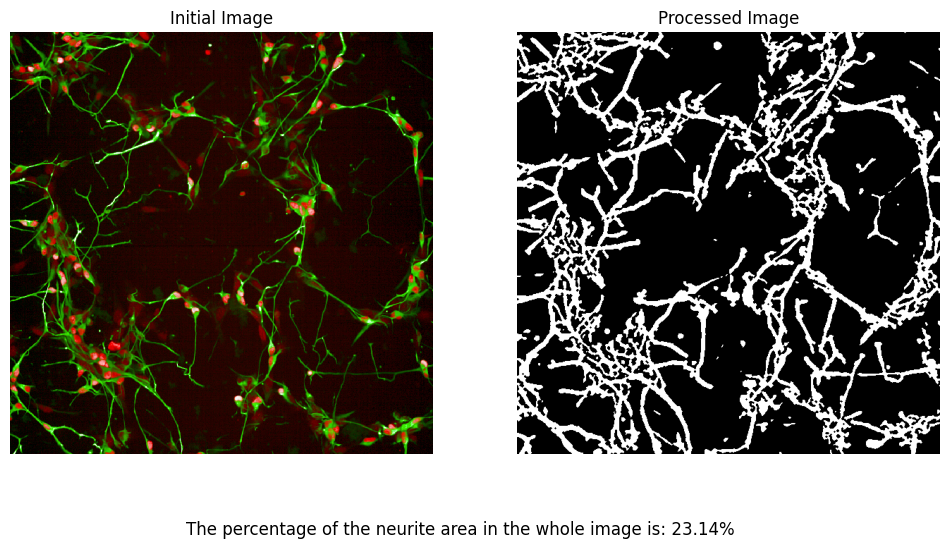

In [15]:
# Show the comparison results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  


axs[0].imshow(neurite_image_rgb)
axs[0].axis('off')  
axs[0].set_title('Initial Image')

axs[1].imshow(morphed_image, cmap='gray')
axs[1].axis('off') 
axs[1].set_title('Processed Image')

plt.figtext(0.5, 0.01, f"The percentage of the neurite area in the whole image is: {area_ratio:.2f}%", ha='center', fontsize=12)

plt.show()

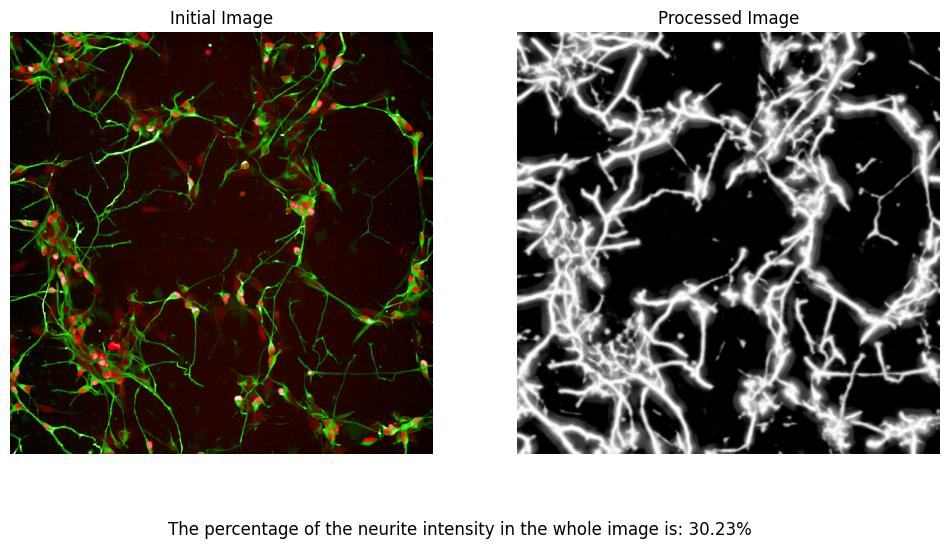

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  


axs[0].imshow(neurite_image_rgb)
axs[0].axis('off')  
axs[0].set_title('Initial Image')


axs[1].imshow(processed_image, cmap='gray')
axs[1].axis('off')  
axs[1].set_title('Processed Image')


plt.figtext(0.5, 0.01, f"The percentage of the neurite intensity in the whole image is: {mean_intensity:.2f}%", ha='center', fontsize=12)


plt.show()